In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product, chain
import numba as nb
from scipy.optimize import fsolve, bisect, minimize, basinhopping, brenth
import matplotlib as mpl
from tqdm.auto import tqdm, trange
import pdb
from math import gamma as ga
from numba import vectorize, float64, njit
import argparse
import sys
import os

SQRT2PI = np.sqrt(2.0 * np.pi)

In [2]:
# # ----------------------------------------
# # Input handling
# # ----------------------------------------

# # Construct the argument parser
# ap = argparse.ArgumentParser()
# ap.add_argument("-p", "--path", type=str, help="Path to the directory.")
# ap.add_argument("-i", "--idx_dataset", type=int, default=0, help="Index of the dataset: 0, ..., 9.")
# ap.add_argument("-w", "--which_limit", type=str, default='a', help="Which experiments: a, b, c, ab, bc, ac or abc.")
# ap.add_argument("-n", "--num", type=int, default=30, help="Nmbr of the points used for one limit.")

# args = vars(ap.parse_args())
# num = args['num']


# definitions

In [3]:
args = {'path': './', 'idx_dataset': 4, 'which_limit': 'a', 'num': 40}
num = args['num']


In [4]:
# ----------------------------------------
# Functions
# ----------------------------------------

# TODO distribution elements should be vectorized instead for loops
# normal distribution
@njit
def pdf_normal(x, loc=0., scale=1.):
    u = (x - loc) / scale
    return np.exp(-0.5 * u ** 2) / (SQRT2PI * scale)


# exponential distribution
@njit
def pdf_expon(x, scale=1.):
    if 0 < x:
        return np.exp(-x / scale) / scale
    return 0


# uniform distribution
@njit
def pdf_uniform(x, loc=0., scale=1.):
    if loc <= x <= loc + scale:
        return 1 / scale
    return 0


# gamma distribution
@njit
def pdf_gamma(x, a=1., scale=1.):
    u = x ** (a - 1) * np.exp(- x / scale)
    return u / ga(a) / scale ** a


def inbounds(value, low, up):
    # utility function for bounds checks
    if value < low:
        return False, 10 ** 50 + 10 ** 50 * np.abs(value - low)
    elif value > up:
        return False, 10 ** 50 + 10 ** 50 * np.abs(value - up)
    else:
        return True, 0


@njit
def density_alice_nb(pars,
                     x,
                     lamb,
                     efficiency
                     ):
    """
    The density function for experiment A.
    """

    density = np.zeros(len(x))

    for i, v in enumerate(x):
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        # flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=20.)
        # peak
        density[i] += pars[2] * pdf_normal(v, loc=6, scale=0.5)
        # rise
        density[i] += pars[3] * pdf_expon(v, scale=0.1)

    # efficiency
    density *= efficiency

    return density


@njit
def density_bob_nb(pars,
                   x,
                   lamb,
                   efficiency
                   ):
    """
    The density function for experiment B.
    """

    density = np.zeros(len(x))

    for i, v in enumerate(x):
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        # flat
        density[i] += pars[1] * pdf_uniform(v, loc=0., scale=10.)
        # peak
        density[i] += pars[2] * pdf_normal(v, loc=6, scale=0.5)
        # rise
        density[i] += pars[3] * pdf_expon(v, scale=0.1)

    # efficiency
    density *= efficiency

    return density


@njit
def density_carol_nb(pars,
                     x,
                     lamb,
                     efficiency
                     ):
    """
    The density function for experiment C.
    """

    density = np.zeros(len(x))

    for i, v in enumerate(x):
        # signal
        density[i] += pars[0] * pdf_expon(v, lamb)
        # gamma
        density[i] += pars[1] * 0.6153846153846154 * pdf_gamma(v, a=2.25, scale=66.67)
        # peak
        density[i] += pars[1] * 0.12307692307692308 * pdf_normal(v, loc=45., scale=2.)
        # peak
        density[i] += pars[1] * 0.1846153846153846 * pdf_normal(v, loc=75., scale=3.)
        # peak
        density[i] += pars[1] * 0.07692307692307693 * pdf_normal(v, loc=120., scale=5.)
        # peak
        density[i] += pars[2] * pdf_normal(v, loc=200., scale=10.)
        # peak
        density[i] += pars[3] * pdf_normal(v, loc=300., scale=20.)

    # efficiency
    density *= efficiency

    return density


In [5]:
def nll_combined(pars,
                 datas,
                 lamb,
                 densities,
                 grids,
                 eff_grid,
                 efficiencies,
                 bnds,
                 npars,
                 exposures):
    """
    The negative extended log likelihood.
    
    grid: 1D array, the grid over the combined ROI of all measurements for the integration
    eff_grid: list of 1D arrays, the efficiencies of the measurements, evaluated at the grid values, 
        set to zero outside the ROI of the measurement
    efficiencies: list of 1D arrays, the efficiencies of the measurements, evaluated at the x values, 
        set to zero outside the ROI of the measurement
    """

    n = len(npars)  # the number of densities/measurements
    nll = 0  # init the count variable for the likelihood
    nu = 0  # init the count variable for the integral over the density

    # loop over the measurements
    for i in range(n):

        # get the correct pars and bounds for this measurement
        ids = int(np.sum(npars[:i]) - i + 1) 
        ide = int(np.sum(npars[:i + 1]) - i)
        #print(ids, ide)
        pars_ = list([pars[0]]) + list(pars[ids:ide])
        bnds_ = list([bnds[0]]) + list(bnds[ids:ide])
        pars_ = np.array(pars_)
        bnds_ = np.array(bnds_)

        # check if the parameters are within their bounds
        for p, (low, up) in zip(pars_, bnds_):
            ok, retval = inbounds(p, low, up)
            if not ok:
                return retval

        # calculate and sum up the likelihood and the integral over the density
        
        #print(pars_, datas[i][0], lamb, efficiencies[i][0])

        lh = densities[i](pars_, datas[i], lamb, efficiencies[i])  # /exposures[i]
        nll -= np.sum(np.log(lh))
        nu += np.trapz(y=densities[i](pars_, grids[i], lamb, eff_grid[i]),
                       x=grids[i])  # /exposures[i]  # integrate in roi
        #print(lh[0], nu, nll)

    return nu + nll  # this is nu - sum(log(lh)), i.e. the negative extended log likelihood


In [6]:
def nll_combined_sigfixed(pars,
                          datas,
                          lamb,
                          densities,
                          grids,
                          eff_grid,
                          efficiencies,
                          sig_fixed,
                          bnds,
                          npars,
                          exposures):
    """
    The negative extended log likelihood.

    grid: 1D array, the grid over the combined ROI of all measurements for the integration
    eff_grid: list of 1D arrays, the efficiencies of the measurements, evaluated at the grid values,
        set to zero outside the ROI of the measurement
    efficiencies: list of 1D arrays, the efficiencies of the measurements, evaluated at the x values,
        set to zero outside the ROI of the measurement
    """

    n = len(npars)  # the number of densities/measurements
    nll = 0  # init the count variable for the likelihood
    nu = 0  # init the count variable for the integral over the density

    # loop over the measurements
    for i in range(n):

        # get the correct pars and bounds for this measurement
        ids = int(np.sum(npars[:i]) - i) 
        ide = int(np.sum(npars[:i + 1]) - i)
        #print(ids, ide)
        pars_ = list([sig_fixed]) + list(pars[ids:ide])
        bnds_ = list([(0, 1e100)]) + list(bnds[ids:ide])
        pars_ = np.array(pars_)
        bnds_ = np.array(bnds_)

        # check if the parameters are within their bounds except signal
        for p, (low, up) in zip(pars_, bnds_):
            ok, retval = inbounds(p, low, up)
            if not ok:
                return retval

        # calculate and sum up the likelihood and the integral over the density
        
        #print(pars_, datas[i][0], lamb, efficiencies[i][0])

        lh = densities[i](pars_, datas[i], lamb, efficiencies[i])  # /exposures[i]
        nll -= np.sum(np.log(lh))
        nu += np.trapz(y=densities[i](pars_, grids[i], lamb, eff_grid[i]),
                       x=grids[i])  # /exposures[i]  # integrate in roi
        #print(lh[0], nu, nll)

    return nu + nll  # this is nu - sum(log(lh)), i.e. the negative extended log likelihood


In [17]:
def get_limit_lh(dm_pars: np.array,  # 1D array of the the DM masses
                 densities: list,  # list of parametric signal + bck for all exp
                 x0s: list,  # list of start values for all exp
                 datas: list,  # list of array with recoil energies
                 grids: list,  # list of the grids of efficiencies
                 efficiencies: list,  # the efficiencies on the grids
                 exposures: list,  # the exposures
                 bndss: list,  # lsit of lists of tuples with bounds of all fit parameters
                 ):
    # TODO return of this function needs to be divided by the sum of exposures

    # get the number of measurements
    npars = [len(x0) for x0 in x0s]

    # combine all start values, datas and bounds into a 1D array
    x0s = [0] + list(chain.from_iterable([x0[1:] for x0 in x0s]))
    bnds = [(0, 5e100)] + list(chain.from_iterable([b[1:] for b in bndss]))

    # here we start with the actual limit calculation
    limit = []
    pbar = tqdm(dm_pars, leave=True)
    for p in pbar:
        pbar.set_description(f"dm mass: {p:.2E}, best fit cs: IN PROGRESS, try exclusion fit: 0")

        # the nll_combined function takes 9 arguments additionally to the parameters
        args_ = (datas,  # x
                 p,  # lamb
                 densities,
                 grids,
                 efficiencies,  # eff_grid
                 [np.interp(d, g, e) for d, g, e in zip(datas, grids, efficiencies)],  # efficiency
                 bnds,  # bnds
                 npars,
                 exposures,  # exposures
                 )

        # calculate best fit
        # TODO very important that the initial best fit is really good!!
        res_best = basinhopping(nll_combined, 
                                x0=x0s, 
                                minimizer_kwargs={'args': args_})  # niter=3, stepsize=10, T=100,
        # res_best = minimize(nll_combined, 
        #                      method='Nelder-Mead',
        #                      x0=x0s, 
        #                      args=args_,
        #                      options={'adaptive': True})  # niter=3, stepsize=10, T=100,

        print('\n lamb: {}, fun: {}, pars best fit: {}'.format(p, res_best.fun, res_best.x))
        
        # do exclusion fit
        def implfunc(val):
            # the nll_combined function takes 10 arguments additionally to the parameters
            args_excl = (datas,  # x
                         p,  # lamb
                         densities,
                         grids,  # grids
                         efficiencies,  # eff_grid
                         [np.interp(d, g, e) for d, g, e in zip(datas, grids, efficiencies)],  # efficiency
                         val,  # sig_fixed
                         bnds[1:],  # bnds, but without signal
                         npars,  # npars
                         exposures,  # exposures
                         )

            res = minimize(nll_combined_sigfixed,
                           method='Nelder-Mead',
                           x0=res_best.x[1:],
                           # x0=x0s[1:],
                           args=args_excl,
                           options={'adaptive': True})
            
            print('lamb: {}, fun: {}, cs val: {}, pars exclusion: {}'.format(p, res.fun, val, res.x))

            return res.fun - res_best.fun - 1.282 ** 2 / 2  # results are negativ, this is llh_best - Z^2/2 - llh_excl l

        success = False
        b = 1e5 * res_best.x[0]
        counts = 0
        while not success:
            assert counts < 100, 'Exceeded limit of tries!'
            pbar.set_description(f"dm mass: {p:.2E}, best fit cs: {res_best.x[0]:.2E}, try exclusion fit: {counts}")
            counts += 1
            try:
                # print(implfunc(res_best.x[0]), implfunc(b))
                res_excl = brenth(implfunc,  # bisect, brenth
                                  a=res_best.x[0],
                                  b=b,  # previously: b=1e9, maxiter=1000
                                  maxiter=100,
                                  rtol=1e-4
                                  )
                success = True
            except ValueError:
                b *= 2
        limit.append(res_excl)

    return limit


In [18]:
# ----------------------------------------
# Constants
# ----------------------------------------

NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 10

data_alice = []
data_bob = []
data_carol = []

for i in range(NMBR_REPETITIONS):
    data_alice.append(np.loadtxt(args['path'] + 'data/alice/data_alice_{}.txt'.format(i)))
    data_bob.append(np.loadtxt(args['path'] + 'data/bob/data_bob_{}.txt'.format(i)))
    data_carol.append(np.loadtxt(args['path'] + 'data/carol/data_carol_{}.txt'.format(i)))

grids = []
efficiencies = []

grids.append(np.loadtxt(args['path'] + 'data/alice/efficiency_alice.txt')[:, 0])
grids.append(np.loadtxt(args['path'] + 'data/bob/efficiency_bob.txt')[:, 0])
grids.append(np.loadtxt(args['path'] + 'data/carol/efficiency_carol.txt')[:, 0])

efficiencies.append(np.loadtxt(args['path'] + 'data/alice/efficiency_alice.txt')[:, 1])
efficiencies.append(np.loadtxt(args['path'] + 'data/bob/efficiency_bob.txt')[:, 1])
efficiencies.append(np.loadtxt(args['path'] + 'data/carol/efficiency_carol.txt')[:, 1])

data_alice = np.array(data_alice)
data_bob = np.array(data_bob)
data_carol = np.array(data_carol)
grids = np.array(grids)
efficiencies = np.array(efficiencies)

In [19]:
# ----------------------------------------
# parameters
# ----------------------------------------

bnds_alice = [(0, 5e100),  # w0   # bounds from zero to number of events
              (0, 5e100),  # w1
              (0, 5e100),  # w2
              (0, 5e100),  # w3
              ]

x0_alice = np.array([0. * len(data_alice[0]) / EFFICIENCY[0],  # w0
                     0.4 * len(data_alice[0]) / EFFICIENCY[0],  # w1
                     0.3 * len(data_alice[0]) / EFFICIENCY[0],  # w2
                     0.3 * len(data_alice[0]) / EFFICIENCY[0],  # w3
                     ])

bnds_bob = [(0, 5e100),  # w0 
            (0, 5e100),  # w1
            (0, 5e100),  # w2
            (0, 5e100),  # w3
            ]

x0_bob = np.array([0. * len(data_bob[0]) / EFFICIENCY[1],  # w0
                   0.35 * len(data_bob[0]) / EFFICIENCY[1],  # w1
                   0.3 * len(data_bob[0]) / EFFICIENCY[1],  # w2
                   0.35 * len(data_bob[0]) / EFFICIENCY[1],  # w3
                   ])

bnds_carol = [(0, 5e100),  # w0 
              (0, 5e100),  # w1
              (0, 5e100),  # w2
              (0, 5e100),  # w3
              ]

x0_carol = np.array([0. * len(data_carol[0]) / EFFICIENCY[2],  # w0
                     0.4 * len(data_carol[0]) / EFFICIENCY[2],  # w1
                     0.15 * len(data_carol[0]) / EFFICIENCY[2],  # w2
                     0.1 * len(data_carol[0]) / EFFICIENCY[2],  # w3
                     ])


# Limit calcs

In [20]:
# ----------------------------------------
# Do the calculation
# ----------------------------------------

i = args['idx_dataset']

print('Calculate individual Limits...')
pars_alice = np.logspace(-1.5, 1, num=num)
pars_bob = np.logspace(-2, 1, num=num)
pars_carol = np.logspace(-0.5, 2, num=num)

if args['which_limit'] == 'a':
    limit_alice = get_limit_lh(dm_pars=pars_alice,
                               densities=[density_alice_nb, ],
                               x0s=[x0_alice, ],
                               datas=[data_alice[i], ],
                               grids=grids[[0, ]],
                               efficiencies=efficiencies[[0, ]],
                               exposures=EXPOSURE[[0, ]],
                               bndss=[bnds_alice, ],
                               ) / EXPOSURE[0]

    np.savetxt(args['path'] + f'data/limit/limit_a_{i}.txt', np.array([pars_alice, limit_alice, ]).T)

if args['which_limit'] == 'b':
    limit_bob = get_limit_lh(dm_pars=pars_bob,
                             densities=[density_bob_nb, ],
                             x0s=[x0_bob, ],
                             datas=[data_bob[i], ],
                             grids=grids[[1, ]],
                             efficiencies=efficiencies[[1, ]],
                             exposures=EXPOSURE[[1, ]],
                             bndss=[bnds_bob, ],
                             ) / EXPOSURE[1]

    np.savetxt(args['path'] + f'data/limit/limit_b_{i}.txt', np.array([pars_bob, limit_bob, ]).T)

if args['which_limit'] == 'c':
    limit_carol = get_limit_lh(dm_pars=pars_carol,
                               densities=[density_carol_nb, ],
                               x0s=[x0_carol, ],
                               datas=[data_carol[i], ],
                               grids=grids[[2, ]],
                               efficiencies=efficiencies[[2, ]],
                               exposures=EXPOSURE[[2, ]],
                               bndss=[bnds_carol, ],
                               ) / EXPOSURE[2]

    np.savetxt(args['path'] + f'data/limit/limit_c_{i}.txt', np.array([pars_carol, limit_carol, ]).T)

print('Calculate two-experiment Limits...')
pars_ab = np.logspace(-2, 1, num=num)
pars_ac = np.logspace(-1.5, 1.8, num=num)
pars_bc = np.logspace(-2, 2, num=num)

if args['which_limit'] == 'ab':
    limit_ab = get_limit_lh(dm_pars=pars_ab,
                            densities=[density_alice_nb, density_bob_nb],
                            x0s=[x0_alice, x0_bob],
                            datas=[data_alice[i], data_bob[i]],
                            grids=grids[[0, 1]],
                            efficiencies=efficiencies[[0, 1]],
                            exposures=EXPOSURE[[0, 1]],
                            bndss=[bnds_alice, bnds_bob],
                            ) / np.sum(EXPOSURE[[0, 1]])

    np.savetxt(args['path'] + f'data/limit/limit_ab_{i}.txt', np.array([pars_ab, limit_ab, ]).T)

if args['which_limit'] == 'ac':
    limit_ac = get_limit_lh(dm_pars=pars_ac,
                            densities=[density_alice_nb, density_carol_nb],
                            x0s=[x0_alice, x0_carol],
                            datas=[data_alice[i], data_carol[i]],
                            grids=grids[[0, 2]],
                            efficiencies=efficiencies[[0, 2]],
                            exposures=EXPOSURE[[0, 2]],
                            bndss=[bnds_alice, bnds_carol],
                            ) / np.sum(EXPOSURE[[0, 2]])

    np.savetxt(args['path'] + f'data/limit/limit_ac_{i}.txt', np.array([pars_ac, limit_ac, ]).T)

if args['which_limit'] == 'bc':
    limit_bc = get_limit_lh(dm_pars=pars_bc,
                            densities=[density_bob_nb, density_carol_nb, ],
                            x0s=[x0_bob, x0_carol, ],
                            datas=[data_bob[i], data_carol[i], ],
                            grids=grids[[1, 2]],
                            efficiencies=efficiencies[[1, 2]],
                            exposures=EXPOSURE[[1, 2]],
                            bndss=[bnds_bob, bnds_carol],
                            ) / np.sum(EXPOSURE[[1, 2]])

    np.savetxt(args['path'] + f'data/limit/limit_bc_{i}.txt', np.array([pars_bc, limit_bc, ]).T)

print('Calculate combined Limit ...')
pars_all = np.logspace(-2, 2, num=num)

if args['which_limit'] == 'abc':
    limit_all = get_limit_lh(dm_pars=pars_all,
                             densities=[density_alice_nb, density_bob_nb, density_carol_nb, ],
                             x0s=[x0_alice, x0_bob, x0_carol, ],
                             datas=[data_alice[i], data_bob[i], data_carol[i], ],
                             grids=grids[[0, 1, 2]],
                             efficiencies=efficiencies[[0, 1, 2]],
                             exposures=EXPOSURE[[0, 1, 2]],
                             bndss=[bnds_alice, bnds_bob, bnds_carol],
                             ) / np.sum(EXPOSURE)

    np.savetxt(args['path'] + f'data/limit/limit_all_{i}.txt', np.array([pars_all, limit_all, ]).T)


Calculate individual Limits...


  0%|          | 0/40 [00:00<?, ?it/s]


 lamb: 0.03162277660168379, fun: -8962.58949792112, pars best fit: [1.64686391e-09 1.33064015e+03 9.54513241e+02 9.31585814e+02]
lamb: 0.03162277660168379, fun: -8962.589497921126, cs val: 1.6468639089493078e-09, pars exclusion: [1330.64029195  954.51324314  931.58565434]
lamb: 0.03162277660168379, fun: -8962.58949721474, cs val: 0.00016468639089493078, pars exclusion: [1330.64023671  954.51315345  931.58554112]
lamb: 0.03162277660168379, fun: -8962.589497921126, cs val: 1.6468639089493078e-09, pars exclusion: [1330.64029195  954.51324314  931.58565434]
lamb: 0.03162277660168379, fun: -8962.589496508346, cs val: 0.00032937278178986156, pars exclusion: [1330.64025961  954.51315784  931.58565164]
lamb: 0.03162277660168379, fun: -8962.589497921126, cs val: 1.6468639089493078e-09, pars exclusion: [1330.64029195  954.51324314  931.58565434]
lamb: 0.03162277660168379, fun: -8962.589495095563, cs val: 0.0006587455635797231, pars exclusion: [1330.64023343  954.51320698  931.58559962]
lamb: 0.

KeyboardInterrupt: 

# example plots

In [19]:
pbest = np.array([ 12.07028795, 648.09056649, 480.67069718, 567.42215283])

In [20]:
dns = density_alice_nb(pars=pbest, 
               x=grids[0],
               lamb=1.,
               efficiency=efficiencies[0])

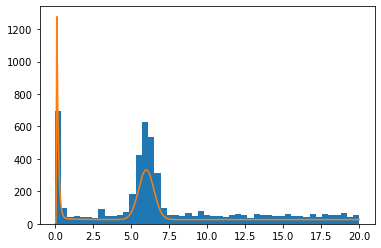

In [21]:
bins = np.linspace(0,20)
plt.hist(data_alice[0], bins=bins, 
         weights=np.ones(data_alice[0].shape[0])/(bins[1] - bins[0]))
plt.plot(grids[0], dns)

In [60]:
i = 0

args_ = ([data_bob[i], ],  # x
         0.1,  # lamb
         [density_bob_nb, ],
         grids[[1, ]],  # grids
         efficiencies[[1, ]],  # eff_grid
         [np.interp(d, g, e) for d, g, e in zip([data_bob[i], ], grids[[1, ]], efficiencies[[1, ]])],  # efficiency
         # pbest[0],  # sig_fixed
         bnds_bob,  # bnds, but without signal
         [4],  # npars
         EXPOSURE[[1, ]],  # exposures
         )

nll_combined(pbest, *args_)


1 4
[1.76720825e-02 6.58421730e+02 4.78304926e+02 5.72425607e+02] 9.848564032126102 0.1 0.65
42.797412450033846 999.8799224088041 -5249.061442138813


-4249.181519730008

In [61]:
i = 0

args_excl = ([data_bob[i], ],  # x
             0.1,  # lamb
             [density_bob_nb, ],
             grids[[1, ]],  # grids
             efficiencies[[1, ]],  # eff_grid
             [np.interp(d, g, e) for d, g, e in zip([data_bob[i], ], grids[[1, ]], efficiencies[[1, ]])],  # efficiency
             pbest[0],  # sig_fixed
             bnds_bob[1:],  # bnds, but without signal
             [3],  # npars
             EXPOSURE[[1, ]],  # exposures
             )

nll_combined_sigfixed(pbest[1:], *args_excl)


0 3
[1.76720825e-02 6.58421730e+02 4.78304926e+02 5.72425607e+02] 9.848564032126102 0.1 0.65
42.797412450033846 999.8799224088041 -5249.061442138813


-4249.181519730008

# check if files worked

In [5]:
dir = '/users/felix.wagner/outputs/'

In [6]:
files = os.listdir(dir)

In [7]:
files = [name for name in files if (name.endswith('.out') and name.startswith('Limit_'))]

In [8]:
which_list = [f.split('_')[1] for f in files[:-1]]
idx_list = [f.split('_')[2].split('.')[0] for f in files[:-1]]
print(which_list)
print(idx_list)

['a', 'a', 'a', 'a', 'bc', 'abc', 'bc', 'bc', 'bc', 'abc', 'abc', 'bc', 'b', 'bc', 'c', 'c', 'b', 'b', 'a', 'ac', 'ab', 'c', 'ab', 'ac', 'b', 'ac', 'c', 'ab', 'ac', 'c', 'ab', 'b', 'ab', 'b', 'ab', 'a', 'ac', 'ac', 'c', 'abc', 'abc', 'abc', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'ab', 'ac', 'ac', 'ac', 'ac', 'ab', 'abc', 'abc', 'abc', 'abc', 'bc', 'ab', 'ab', 'bc', 'bc']
['0', '1', '2', '3', '0', '1', '2', '1', '3', '2', '0', '5', '4', '4', '2', '1', '1', '3', '4', '4', '2', '3', '5', '3', '0', '0', '0', '0', '5', '5', '3', '2', '1', '5', '4', '5', '1', '2', '4', '3', '4', '5', '7', '8', '6', '9', '6', '7', '8', '9', '6', '7', '9', '8', '6', '7', '8', '6', '9', '7', '6', '8', '9', '7', '6', '9', '8', '7', '8']


In [9]:
good_files = []
good_msg = []
bad_files = []
bad_msg = []

for f in files:
    with open(dir + f, 'r') as file:
        data = file.read().split('\n')
        if 'AssertionError: Exceeded limit of tries!' in data[-10:]:
            bad_files.append(f)
            bad_msg.append(data[-10:])
        else:
            good_files.append(f)
            good_msg.append(data[-10:])

In [10]:
print('Nmbr good: ', len(good_files))
print('Nmbr bad: ', len(bad_files))

Nmbr good:  70
Nmbr bad:  0


In [13]:
good_files

['Limit_a_0.out',
 'Limit_a_1.out',
 'Limit_a_2.out',
 'Limit_a_3.out',
 'Limit_bc_0.out',
 'Limit_abc_1.out',
 'Limit_bc_2.out',
 'Limit_bc_1.out',
 'Limit_bc_3.out',
 'Limit_abc_2.out',
 'Limit_abc_0.out',
 'Limit_bc_5.out',
 'Limit_b_4.out',
 'Limit_bc_4.out',
 'Limit_c_2.out',
 'Limit_c_1.out',
 'Limit_b_1.out',
 'Limit_b_3.out',
 'Limit_a_4.out',
 'Limit_ac_4.out',
 'Limit_ab_2.out',
 'Limit_c_3.out',
 'Limit_ab_5.out',
 'Limit_ac_3.out',
 'Limit_b_0.out',
 'Limit_ac_0.out',
 'Limit_c_0.out',
 'Limit_ab_0.out',
 'Limit_ac_5.out',
 'Limit_c_5.out',
 'Limit_ab_3.out',
 'Limit_b_2.out',
 'Limit_ab_1.out',
 'Limit_b_5.out',
 'Limit_ab_4.out',
 'Limit_a_5.out',
 'Limit_ac_1.out',
 'Limit_ac_2.out',
 'Limit_c_4.out',
 'Limit_abc_3.out',
 'Limit_abc_4.out',
 'Limit_abc_5.out',
 'Limit_a_7.out',
 'Limit_a_8.out',
 'Limit_a_6.out',
 'Limit_a_9.out',
 'Limit_b_6.out',
 'Limit_b_7.out',
 'Limit_b_8.out',
 'Limit_b_9.out',
 'Limit_c_6.out',
 'Limit_c_7.out',
 'Limit_c_9.out',
 'Limit_c_8.out'